# <center>Clustering Assignment</center>
### <center>Gianmaria Carnazzi, Giulio Mantoan, Giacomo Miolo</center>
#### <center>29/03/2020</center>

## Import libraries and data

In [1]:
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
from matplotlib.cbook import boxplot_stats

# Stats
from scipy.stats import skew, kurtosis

# Scaling
from sklearn.preprocessing import StandardScaler

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Clustering Algorithms
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import pdist, squareform

from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score

from IPython.display import Image

In [2]:
df = pd.read_csv("/Users/giacomomiolo/Downloads/pc_data.csv")

## Reproducibility

In [3]:
!python --version

Python 3.7.6


In [4]:
!jupyter --version

jupyter core     : 4.6.3
jupyter-notebook : 6.0.3
qtconsole        : 4.7.1
ipython          : 7.13.0
ipykernel        : 5.2.0
jupyter client   : 6.1.0
jupyter lab      : 2.0.1
nbconvert        : 5.6.1
ipywidgets       : 7.5.1
nbformat         : 5.0.4
traitlets        : 4.3.3


In [5]:
!jupyter labextension list

JupyterLab v2.0.1
Known labextensions:
   app dir: /Users/giacomomiolo/opt/anaconda3/share/jupyter/lab
        @jupyter-widgets/jupyterlab-manager v2.0.0  enabled  OK
        ipyvolume v0.5.2  enabled  OK
        jupyter-threejs v2.2.0  enabled  OK
        jupyterlab-datawidgets v6.2.0  enabled  OK
        jupyterlab-plotly v1.5.4  enabled  OK
        plotlywidget v1.5.4  enabled  OK

Uninstalled core extensions:
    jupyter-threejs


In [6]:
import pkg_resources
import types
def get_imports():
    '''This function prints all the packages used in this notebook and their version.'''
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split(".")[0]
        elif isinstance(val, type):
            name = val.__module__.split(".")[0]
        poorly_named_packages = {"sklearn": "scikit-learn"}
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name
imports = [*set(get_imports())]

requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print(f"{r[0]} {r[1]}")

seaborn 0.10.0
scikit-learn 0.22.2
plotly 4.5.4
pandas 1.0.3
numpy 1.17.2
matplotlib 3.2.1


## Exploratory Data Analysis

Dataset description

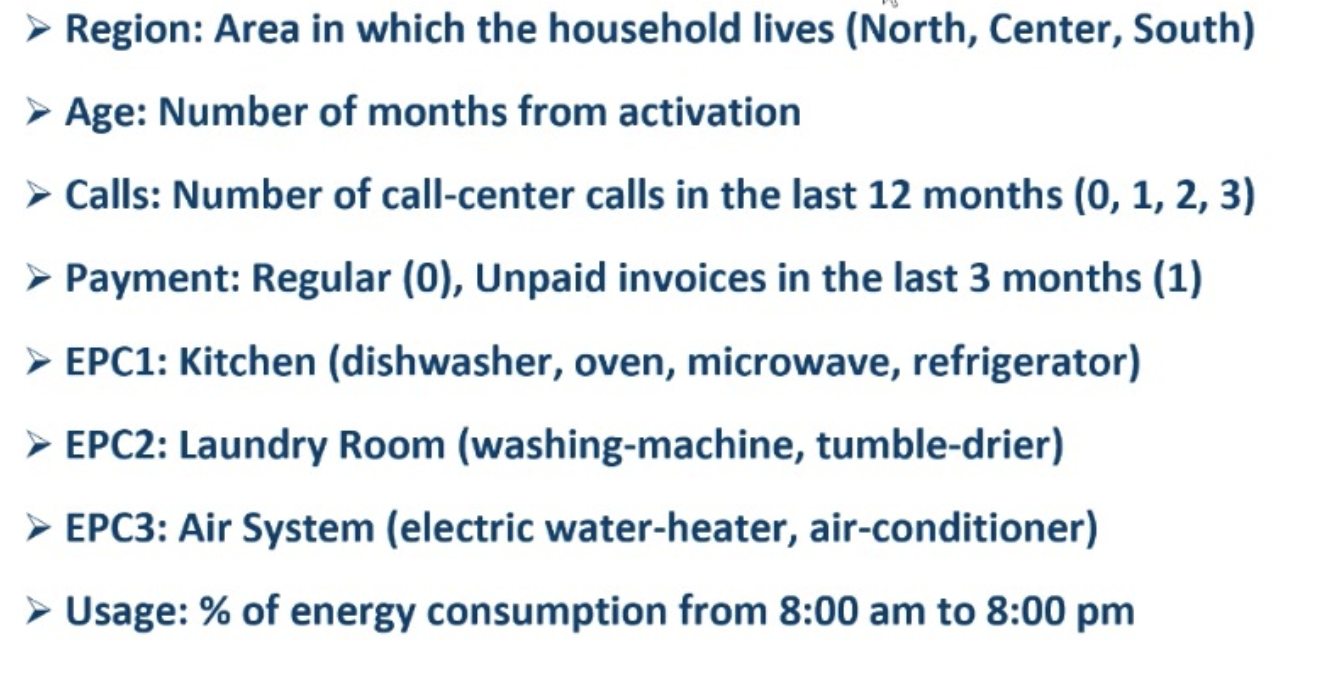

In [7]:
Image("/Users/giacomomiolo/Desktop/Screenshot 2020-03-20 at 13.31.09.png", width=600, height=300)

In [8]:
X = df.copy()

In [9]:
X.head()

EPC1  EPC2  EPC3  Usage  Payment  Calls  Region  Age
0    50    67    25   0.86        1      3   North   25
1    45    78    47   0.94        0      1  Center   13
2    47    71    33   0.91        0      2  Center   20
3    42    73    54   0.94        0      1  Center   18
4    36    65    32   0.94        0      2   North   21

In [10]:
cols = [*X.columns]
cols

['EPC1', 'EPC2', 'EPC3', 'Usage', 'Payment', 'Calls', 'Region', 'Age']

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   EPC1     1000 non-null   int64  
 1   EPC2     1000 non-null   int64  
 2   EPC3     1000 non-null   int64  
 3   Usage    1000 non-null   float64
 4   Payment  1000 non-null   int64  
 5   Calls    1000 non-null   int64  
 6   Region   1000 non-null   object 
 7   Age      1000 non-null   int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 62.6+ KB


In [12]:
num = X[['EPC1', 'EPC2', 'EPC3', 'Usage', 'Calls', 'Age']]
cat = X[['Payment', 'Region']] # Calls categorical?

In [13]:
def describe_cat(df, col):
    print(f'{col} - {df[col].nunique()} unique values.')
    missing_count = df[col].isnull().sum()
    if missing_count != 0:
        total = len(df[col])
        missing_perc = (missing_count/total)*100
        
        print(f'! Missing values: perc - {missing_perc:0.3f}% count - {missing_count}')
    else:
        print(f'No missing values.\n')
    count = df[col].value_counts(sort=True, dropna=True)
    perc = df[col].value_counts(normalize=True, sort=True, ascending=False, dropna=True)*100
    d = pd.concat([perc, count], axis=1, keys=['Percentage %', 'Count'])
    print(d)
    print('-------------------------')

In [14]:
for col in cat.columns:
    describe_cat(X, col)

Payment - 2 unique values.
No missing values.

   Percentage %  Count
0          89.1    891
1          10.9    109
-------------------------
Region - 3 unique values.
No missing values.

        Percentage %  Count
North           45.0    450
South           28.2    282
Center          26.8    268
-------------------------


### Numerical features

EPC1
Skewness: -0.012, Kurtosis: -0.477


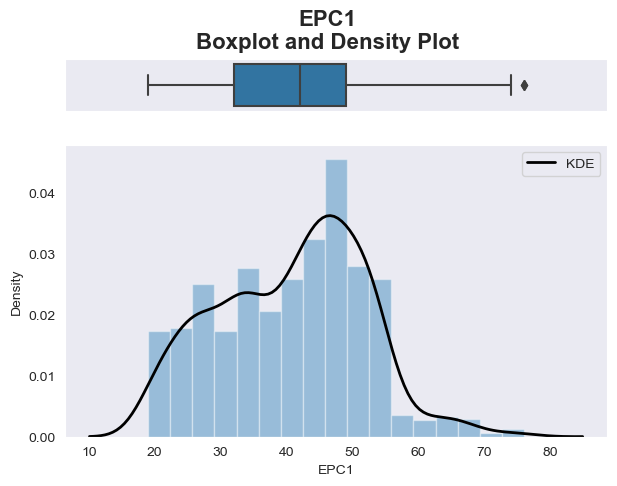

EPC2
Skewness: 0.277, Kurtosis: -0.572


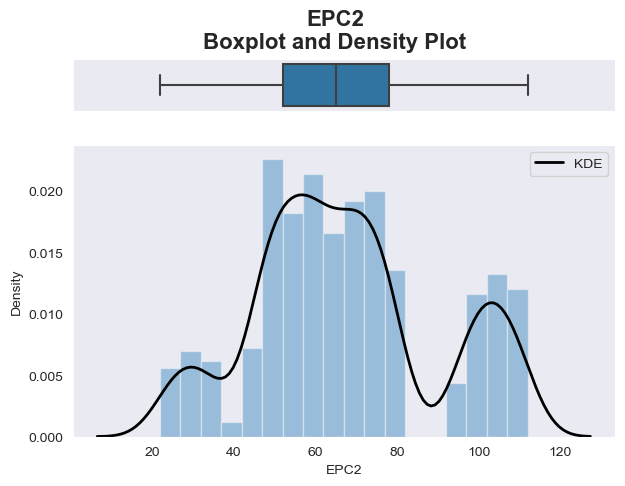

EPC3
Skewness: -0.070, Kurtosis: -1.224


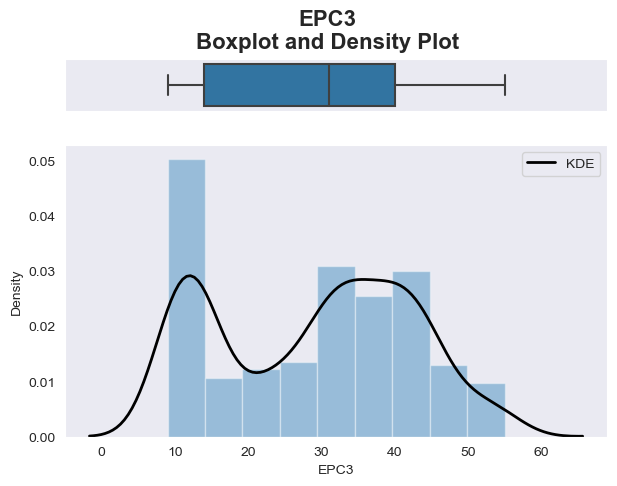

Usage
Skewness: -0.935, Kurtosis: -0.792


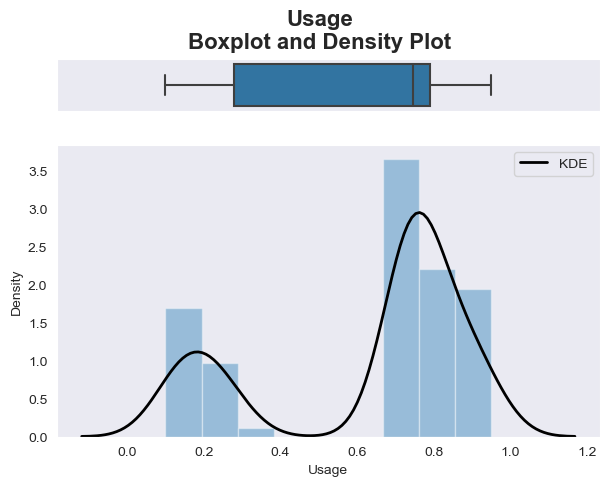

Calls
Skewness: 0.366, Kurtosis: -0.603


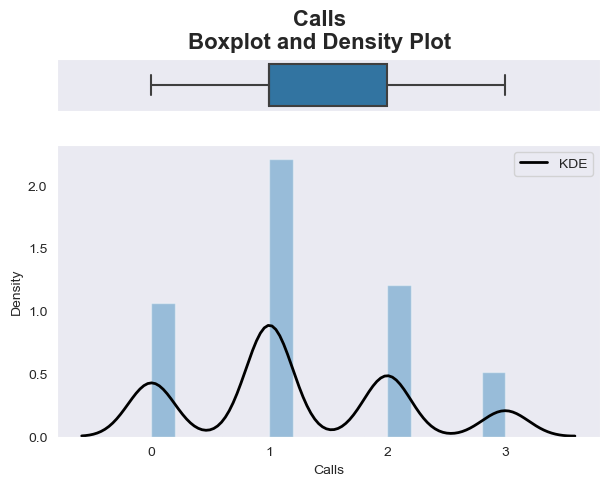

Age
Skewness: -0.436, Kurtosis: -0.764


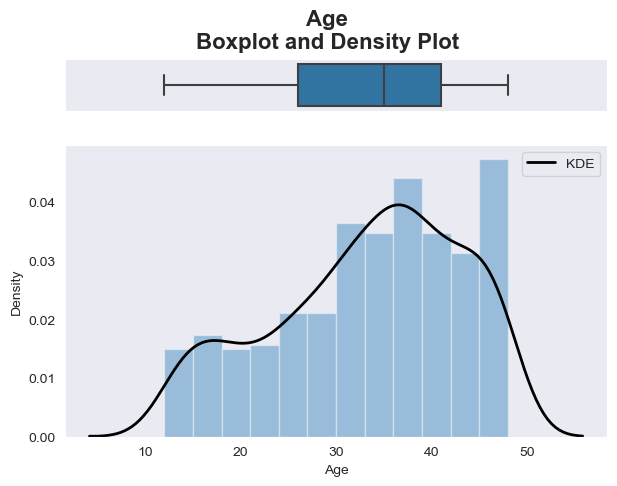

In [15]:
sns.set_style("dark")

for i in num.columns:
    fig, axes = plt.subplots(2, sharex=True, figsize=(7, 5), dpi=100, gridspec_kw={"height_ratios": (.15, .85)})
    fig.suptitle(f'{i}\nBoxplot and Density Plot', fontweight='bold', fontsize=16)
    sns.boxplot(X[i], ax=axes[0])
    axes[0].set_title('')
    axes[0].set_xlabel('')
    axes[0].set_ylabel('')
    sns.distplot(X[i],
                 kde_kws={"color": "black", "lw": 2, "label": "KDE"},
                 hist_kws={"histtype": "bar", "linewidth": 1, "alpha": 0.4},
                 ax=axes[1])
   # axes[1].set_title('')
    axes[1].set_xlabel(f'{i}')
    axes[1].set_ylabel('Density')
    print(f"{i}\nSkewness: {skew(X[i]):0.3f}, Kurtosis: {kurtosis(X[i]):0.3f}")
    plt.show()

#### Comments
* **EPC1**: Potential outlier
* **Usage**: Could be discretized into low usage (values around 0.2) and high usage (values around 0.8)
* **Calls**: Could be interpreted as categorical given that there are only 4 unique values

### Correlations

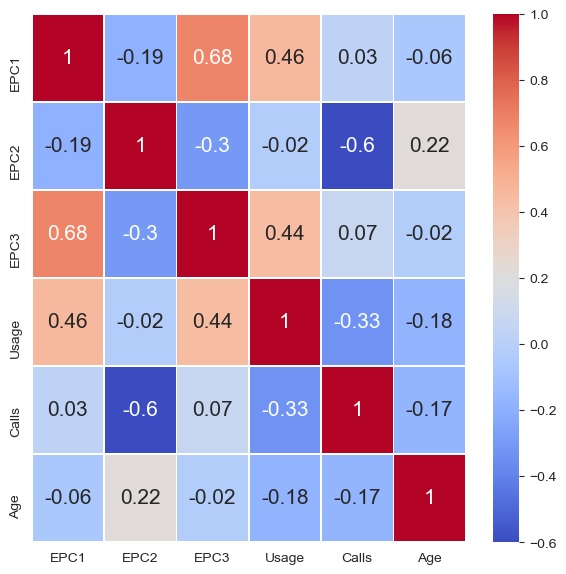

In [16]:
plt.figure(figsize = (7,7), dpi=100)
sns.heatmap(data=num.corr().round(2), cmap='coolwarm', linewidths=.5, annot=True, annot_kws={"size":15})
plt.show()

#### Comments
* **EPC1** and **EPC3** are positively correlated.
* **EPC2** and **Calls** are negatively correlated.
* **Usage** is positively correlated with **EPC1** and **EPC3** but it doesn't seem to be correlated with **EPC2**. It could mean that the power consumption of Kitchen (EPC1) and Air System (EPC3) is mostly concentrated between 8am and 8pm (day-hours), whereas power consumptio of Laundry (EPC2) could be concentrated between 8pm and 8am (night-hours).
* **Usage** and **Calls** are negatively correlated.

### Pairplots

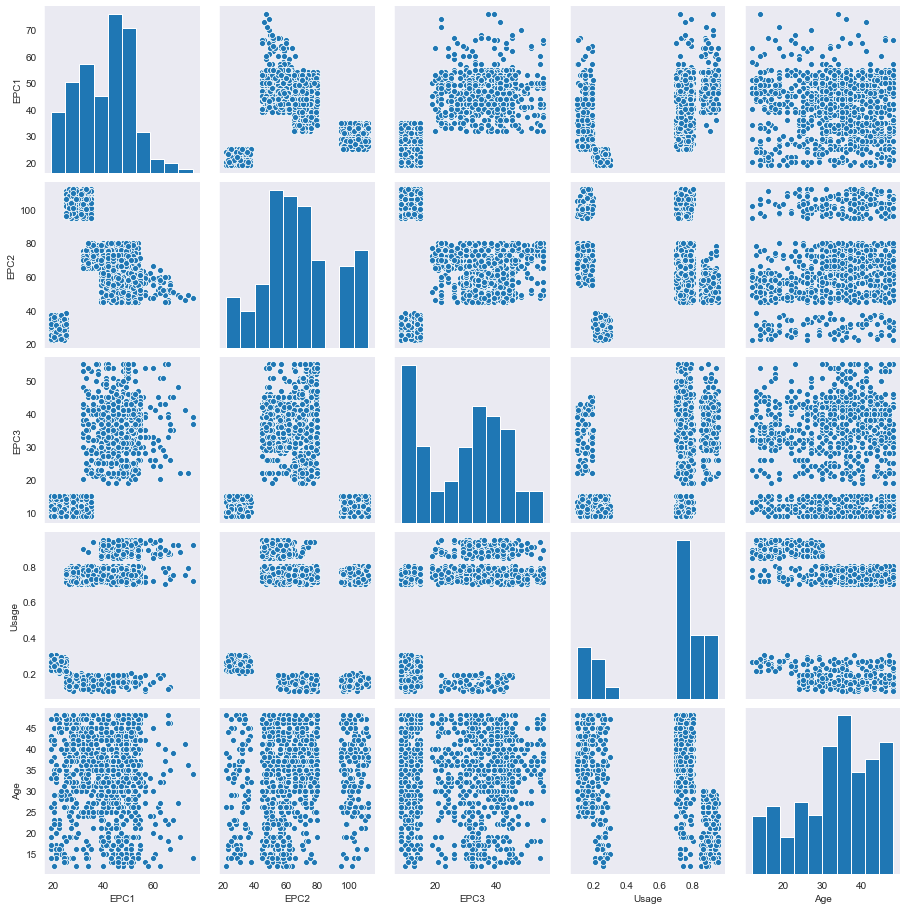

In [17]:
sns.pairplot(X, vars=["EPC1", "EPC2", "EPC3", "Usage", "Age"], corner=False)
# plt.savefig("Pairplot.png")
plt.show()

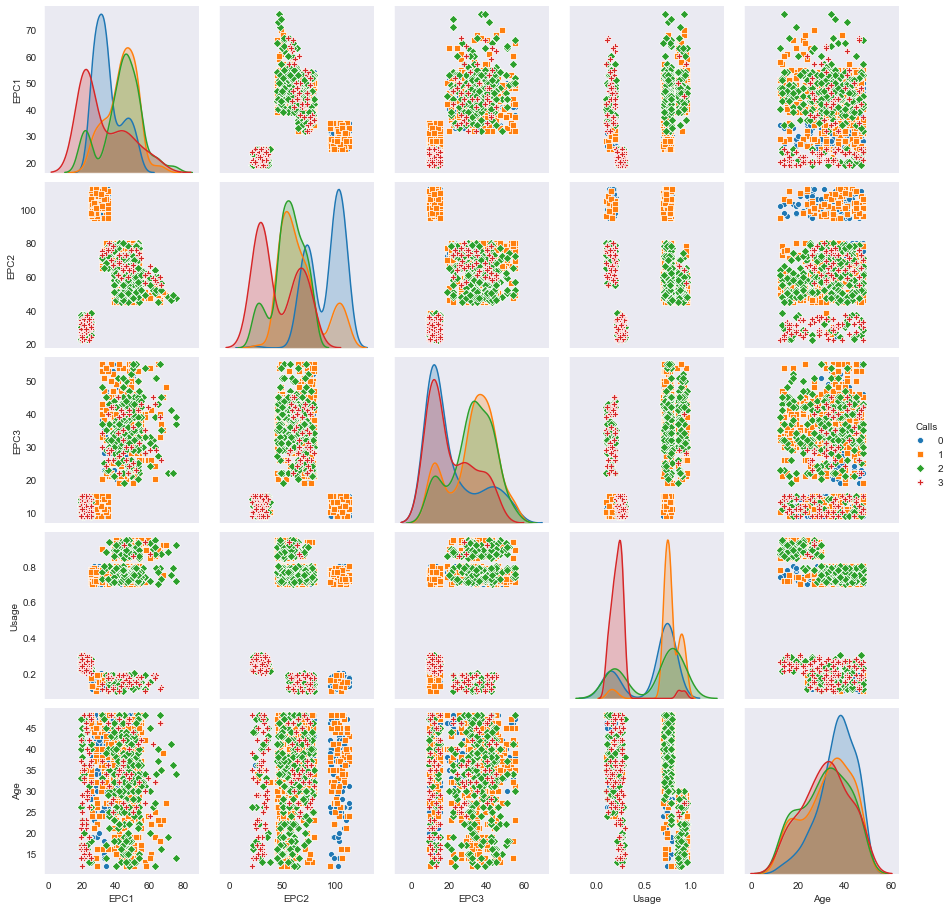

In [18]:
sns.pairplot(X, vars=["EPC1", "EPC2", "EPC3", "Usage", "Age"], corner=False, hue="Calls", markers=["o", "s", "D", "P"])
# plt.savefig("PairplotHueCalls.png")
plt.show()

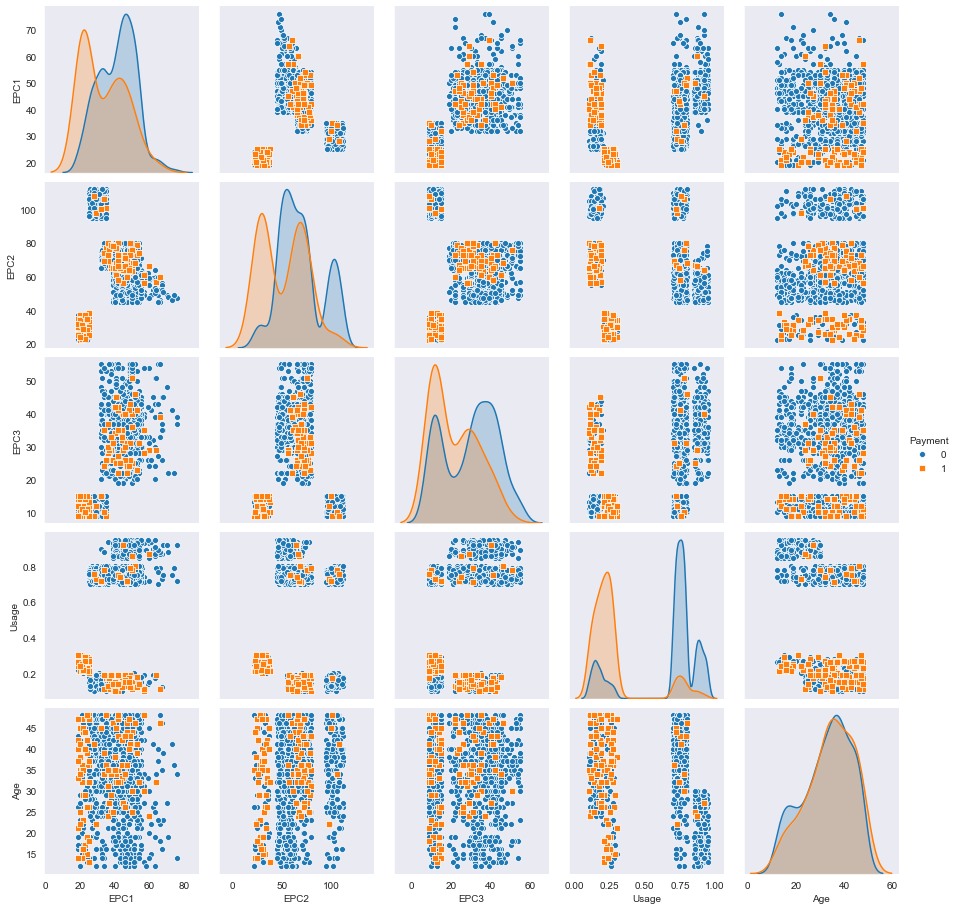

In [19]:
sns.pairplot(X, vars=["EPC1", "EPC2", "EPC3", "Usage", "Age"], corner=False, hue="Payment", markers=["o", "s"])
# plt.savefig("PairplotHuePayment.png")
plt.show()

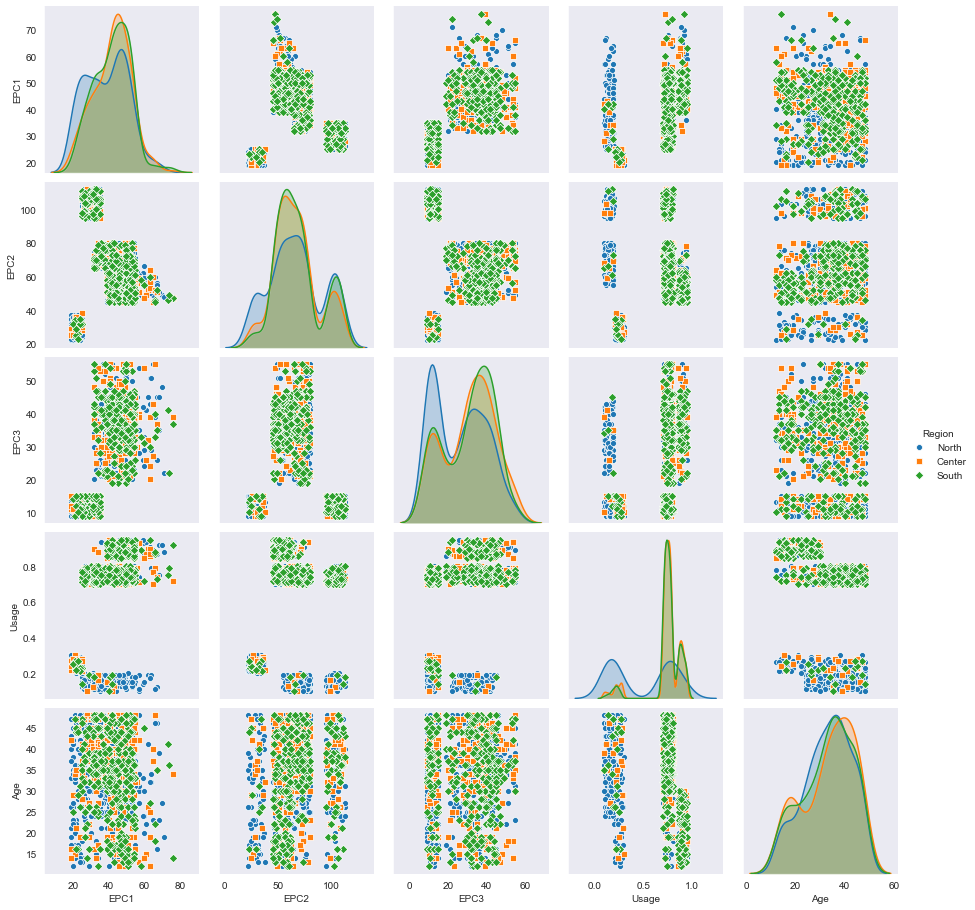

In [20]:
sns.pairplot(X, vars=["EPC1", "EPC2", "EPC3", "Usage", "Age"], corner=False, hue="Region", markers=["o", "s", "D"])
# plt.savefig("PairplotHueRegion.png")
plt.show()

## Scaling

#### Original distributions

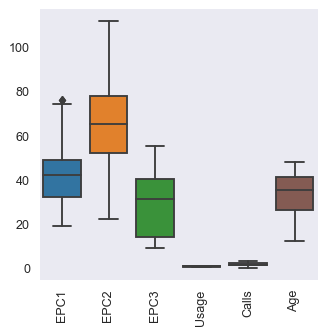

In [21]:
fig = plt.figure(figsize=(4, 4), dpi=90) 
ax = sns.boxplot(data=num)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

#### Standard Scaler

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_X = scaler.fit_transform(num)
scaled_df = pd.DataFrame(scaled_X, columns=[f"{i}_scaled" for i in num.columns])

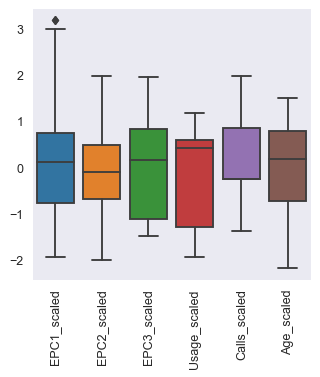

In [23]:
fig = plt.figure(figsize=(4, 4), dpi=90) 
ax = sns.boxplot(data=scaled_df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

#### Robust Scaler

In [24]:
# from sklearn.preprocessing import RobustScaler
# scaler = RobustScaler()
# robust_scaled_X = scaler.fit_transform(num)
# robust_scaled_df = pd.DataFrame(robust_scaled_X, columns=num.columns)

In [25]:
# fig = plt.figure(figsize=(4, 4), dpi=90) 
# ax = sns.boxplot(data=robust_scaled_df)
# ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
# plt.show()

#### Comparison 

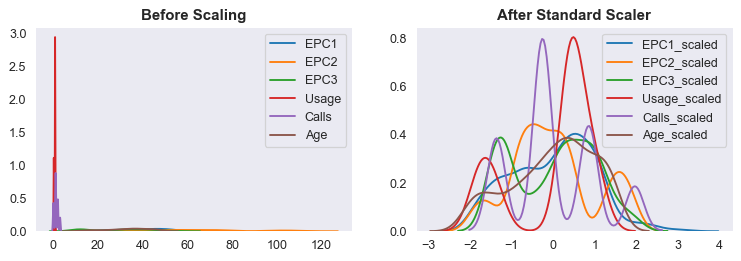

In [26]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3), dpi=90)

ax1.set_title('Before Scaling', fontweight='bold', fontsize=12)
for i in num.columns:
    sns.kdeplot(num[i], ax=ax1)

ax2.set_title('After Standard Scaler', fontweight='bold', fontsize=12)
for j in scaled_df.columns:
    sns.kdeplot(scaled_df[j], ax=ax2)

#### Dummies

In [27]:
cat_dummies = pd.get_dummies(cat)

In [28]:
cat_dummies.head()

Payment  Region_Center  Region_North  Region_South
0        1              0             1             0
1        0              1             0             0
2        0              1             0             0
3        0              1             0             0
4        0              0             1             0

In [29]:
scaled_df.head()

EPC1_scaled  EPC2_scaled  EPC3_scaled  Usage_scaled  Calls_scaled  \
0     0.834583    -0.019365    -0.299631      0.838198      1.958966   
1     0.385351     0.468082     1.347928      1.131057     -0.260825   
2     0.565044     0.157888     0.299481      1.021235      0.849070   
3     0.115812     0.246515     1.872151      1.131057     -0.260825   
4    -0.423266    -0.107992     0.224592      1.131057      0.849070   

   Age_scaled  
0   -0.843981  
1   -2.066994  
2   -1.353570  
3   -1.557405  
4   -1.251652

In [30]:
X = pd.concat([scaled_df, cat_dummies], axis=1)
X.head()

EPC1_scaled  EPC2_scaled  EPC3_scaled  Usage_scaled  Calls_scaled  \
0     0.834583    -0.019365    -0.299631      0.838198      1.958966   
1     0.385351     0.468082     1.347928      1.131057     -0.260825   
2     0.565044     0.157888     0.299481      1.021235      0.849070   
3     0.115812     0.246515     1.872151      1.131057     -0.260825   
4    -0.423266    -0.107992     0.224592      1.131057      0.849070   

   Age_scaled  Payment  Region_Center  Region_North  Region_South  
0   -0.843981        1              0             1             0  
1   -2.066994        0              1             0             0  
2   -1.353570        0              1             0             0  
3   -1.557405        0              1             0             0  
4   -1.251652        0              0             1             0

## Dimensionality Reduction

### Principal Component Analysis 

In [31]:
n_components = 7
pca = PCA(n_components)
pca.fit(X)
X_pca = pd.DataFrame(pca.transform(X), columns = [f"PC{i}" for i in range(1,n_components+1)])
print(f"From {X.shape[1]} dimensions to {X_pca.shape[1]}.")

From 10 dimensions to 7.


In [32]:
cum_explained_var = np.cumsum(pca.explained_variance_ratio_)
cum_explained_var_df = pd.DataFrame(cum_explained_var, index = [f"PC{i}" for i in range(1,X_pca.shape[1]+1)]).transpose()
explained_var = pd.DataFrame(pca.explained_variance_ratio_).transpose()
cum_explained_var_df

PC1       PC2       PC3       PC4       PC5       PC6       PC7
0  0.32926  0.591673  0.742112  0.822875  0.871607  0.915133  0.955231

Total explained variance with 7 components: 95.52 %


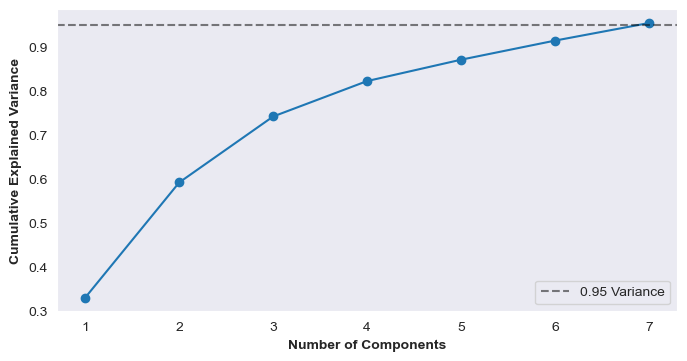

In [33]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=100)

plt.plot(cum_explained_var, linestyle='-', marker='o')
ax.set_xlabel('Number of Components', fontweight='bold')
ax.set_ylabel('Cumulative Explained Variance', fontweight='bold')
ax.axhline(0.95, ls='--', color="black", label="0.95 Variance", alpha=0.5)
ax.set_xticklabels(range(len(cum_explained_var)+1))
plt.legend()
print(f"Total explained variance with {X_pca.shape[1]} components: {cum_explained_var[-1]*100:0.2f} %")
plt.show()

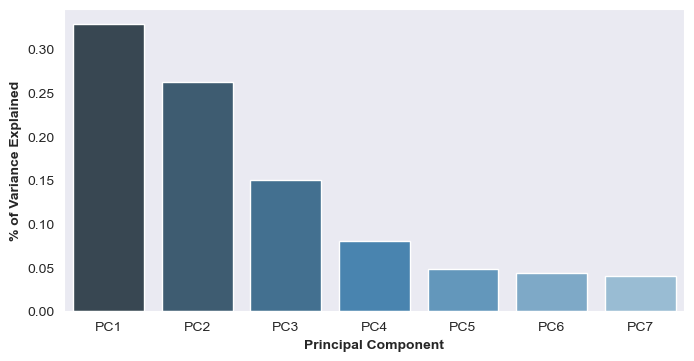

In [34]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
sns.barplot(data=explained_var, palette="Blues_d")
ax.set_xlabel("Principal Component", fontweight='bold')
ax.set_ylabel("% of Variance Explained", fontweight='bold')
ax.set_xticklabels([f"PC{i}" for i in range(1,X_pca.shape[1]+1)])
plt.show()

In [35]:
pd.DataFrame(pca.components_,index=[f"PC{i}" for i in range(1,X_pca.shape[1]+1)],columns=X.columns)

EPC1_scaled  EPC2_scaled  EPC3_scaled  Usage_scaled  Calls_scaled  \
PC1     0.562861    -0.292674     0.574491      0.465712      0.065840   
PC2    -0.079175    -0.567694    -0.018331     -0.358699      0.680992   
PC3    -0.211856     0.020292    -0.277099      0.289830     -0.115117   
PC4     0.462022     0.504872     0.167986     -0.464587      0.040388   
PC5     0.357589     0.347337    -0.478838      0.256868      0.551702   
PC6     0.476459    -0.387404    -0.571860      0.046105     -0.302500   
PC7    -0.044721     0.193525     0.065173     -0.002294      0.186783   

     Age_scaled   Payment  Region_Center  Region_North  Region_South  
PC1   -0.166190 -0.053781       0.049817     -0.102472      0.052655  
PC2   -0.212335  0.114362      -0.053292      0.116864     -0.063572  
PC3   -0.879722 -0.045121       0.014115     -0.054082      0.039967  
PC4   -0.341930  0.006915      -0.175996      0.335508     -0.159512  
PC5    0.111571  0.024052      -0.019162     -0.253353      0.272514  
PC6    0.081303 -0.022277       0.070278      0.271238     -0.341516  
PC7   -0.031938 -0.003312       0.753695     -0.192062     -0.561633

In [36]:
print(f"Explained variance with 2 component: {cum_explained_var[1]*100:0.2f} %")
print(f"Explained variance with 3 component: {cum_explained_var[4]*100:0.2f} %")

Explained variance with 2 component: 59.17 %
Explained variance with 3 component: 87.16 %


#### Comments
* PC1 shows a high correlation with EPC1, EPC3, Usage and a correlation with EPC2.
* PC2 shows a high correlation with Calls, EPC2, Usage and a correlation with Age

#### Visualizations

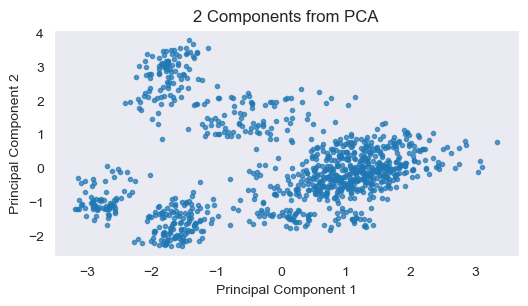

In [37]:
# 2D graph

fig, ax = plt.subplots(figsize=(6, 3), dpi=100)
ax.set_title('2 Components from PCA')
ax.set_xlabel('Component: 1')
ax.set_ylabel('Component: 2')

ax.scatter(X_pca['PC1'], X_pca['PC2'], marker='.',alpha=0.7)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')

plt.show()

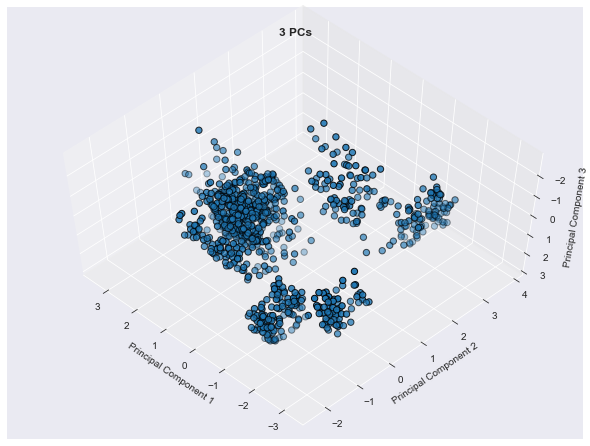

In [38]:
# 3D graph

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-120, azim=45)
ax.scatter(X_pca['PC1'], X_pca['PC2'], X_pca['PC3'], cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("3 PCs", fontweight="bold")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")

plt.savefig("3PCs.png")
plt.show()

In [39]:
# 3D interactive graph

import plotly.express as px

fig = px.scatter_3d(X_pca,
                    x="PC1",
                    y="PC2",
                    z="PC3",
                    template="plotly_dark",
                   opacity=0.8)
fig.show()

## Clustering Models

### DBScan

In [40]:
def dbscan_clustering(X, n_components = None, scale = False, df = df, **dbscan_params): 
    if scale:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        
    dopca = n_components is None or n_components > 0
    
    if dopca:
            pca = PCA(n_components=n_components, copy=True, whiten=False, svd_solver='auto', 
                      tol=0.0, iterated_power='auto', random_state=None)
            X = pca.fit_transform(X)

    db = DBSCAN(**dbscan_params)
    #metrics: sqeuclidean, chebyshev, cosine
    db.fit(X) 
   
    return db

#### Using CALLS as categorical feature:

In [41]:
X = df.copy()
num = X[['EPC1', 'EPC2', 'EPC3', 'Usage', 'Age']]
cat = X[['Calls', 'Payment', 'Region']] # Calls categorical.

In [42]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(num)
scaled_df = pd.DataFrame(scaled_X, columns=[f"{i}_scaled" for i in num.columns])

In [43]:
cat_dummies = pd.get_dummies(cat, columns = ["Calls", "Region"])

In [44]:
X = pd.concat([scaled_df, cat_dummies], axis=1)
X.head()

EPC1_scaled  EPC2_scaled  EPC3_scaled  Usage_scaled  Age_scaled  Payment  \
0     0.834583    -0.019365    -0.299631      0.838198   -0.843981        1   
1     0.385351     0.468082     1.347928      1.131057   -2.066994        0   
2     0.565044     0.157888     0.299481      1.021235   -1.353570        0   
3     0.115812     0.246515     1.872151      1.131057   -1.557405        0   
4    -0.423266    -0.107992     0.224592      1.131057   -1.251652        0   

   Calls_0  Calls_1  Calls_2  Calls_3  Region_Center  Region_North  \
0        0        0        0        1              0             1   
1        0        1        0        0              1             0   
2        0        0        1        0              1             0   
3        0        1        0        0              1             0   
4        0        0        1        0              0             1   

   Region_South  
0             0  
1             0  
2             0  
3             0  
4             0

In [45]:
n_components = 5
pca = PCA(n_components)
pca.fit(X)
X_pca = pd.DataFrame(pca.transform(X), columns = [f"PC{i}" for i in range(1,n_components+1)])

In [46]:
db = dbscan_clustering(X_pca, eps=0.75, min_samples=10, metric='sqeuclidean')
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
unique_labels = set(labels)
print(n_clusters_)
print(n_noise_) 

5
34


Silhouette score: 0.27629447656811473


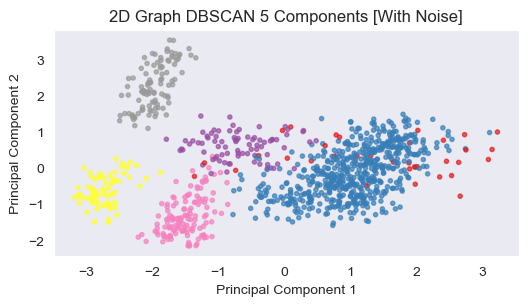

In [47]:
# 2D graph

fig, ax = plt.subplots(figsize=(6, 3), dpi=100)
ax.set_title('2D Graph DBSCAN 5 Components [With Noise]')
ax.set_xlabel('Component: 1')
ax.set_ylabel('Component: 2')

ax.scatter(X_pca['PC1'], X_pca['PC2'], c=labels, cmap=plt.cm.Set1, marker='.',alpha=0.7)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
print(f"Silhouette score: {silhouette_score(X, labels)}")
plt.show()

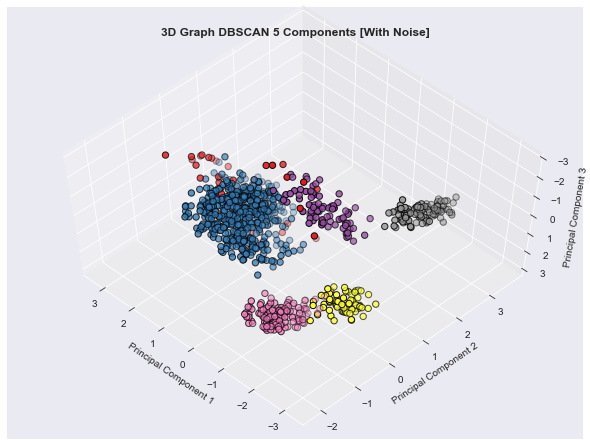

In [48]:
# 3D graph

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-120, azim=45)
ax.scatter(X_pca['PC1'], X_pca['PC2'], X_pca['PC3'], c=labels, cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("3D Graph DBSCAN 5 Components [With Noise]", fontweight="bold")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")

# plt.savefig("3PCs.png")
plt.show()

In [49]:
# 3D interactive graph

import plotly.express as px

fig = px.scatter_3d(X_pca,
                    x="PC1",
                    y="PC2",
                    z="PC3",
                    template="plotly_dark",
                    color=labels,
                    color_continuous_scale="Viridis",
                   opacity=0.8)
fig.show()

In [50]:
X_pca

PC1       PC2       PC3       PC4       PC5
0    0.591621  0.481136  0.639602  0.560308  0.565448
1    1.882857  0.143613  1.818605  0.504248 -1.078568
2    1.220949  0.271032  1.249186  0.339685  0.433782
3    2.007348  0.041566  1.271282  0.188542 -1.467125
4    0.578150  0.675006  1.201544  0.134526 -0.093276
..        ...       ...       ...       ...       ...
995  0.110186  0.446534 -0.050995  0.128151  0.177337
996  0.459267 -0.728756 -0.796428 -0.997004 -0.340809
997  0.269897  0.333646  0.393089 -0.066925 -0.496514
998  0.904246 -0.056909  0.131455 -0.514141 -0.554734
999  0.833069 -0.349239 -0.610176 -0.528652  0.092560

[1000 rows x 5 columns]

In [51]:
X_pca['labels'] = labels
print(X_pca['labels'].value_counts())

 0    579
 3    133
 4    100
 1     81
 2     73
-1     34
Name: labels, dtype: int64


In [52]:
X = X_pca
X

PC1       PC2       PC3       PC4       PC5  labels
0    0.591621  0.481136  0.639602  0.560308  0.565448       0
1    1.882857  0.143613  1.818605  0.504248 -1.078568      -1
2    1.220949  0.271032  1.249186  0.339685  0.433782       0
3    2.007348  0.041566  1.271282  0.188542 -1.467125      -1
4    0.578150  0.675006  1.201544  0.134526 -0.093276       0
..        ...       ...       ...       ...       ...     ...
995  0.110186  0.446534 -0.050995  0.128151  0.177337       0
996  0.459267 -0.728756 -0.796428 -0.997004 -0.340809       0
997  0.269897  0.333646  0.393089 -0.066925 -0.496514       0
998  0.904246 -0.056909  0.131455 -0.514141 -0.554734       0
999  0.833069 -0.349239 -0.610176 -0.528652  0.092560       0

[1000 rows x 6 columns]

In [53]:
clust_0 = X.loc[X['labels']==0]
clust_1 = X.loc[X['labels']==1]
clust_2 = X.loc[X['labels']==2]
clust_3 = X.loc[X['labels']==3]
clust_4 = X.loc[X['labels']==4]

mean0 = pd.DataFrame(clust_0[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']].mean()).transpose()
mean1 = pd.DataFrame(clust_1[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']].mean()).transpose()
mean2 = pd.DataFrame(clust_2[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']].mean()).transpose()
mean3 = pd.DataFrame(clust_3[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']].mean()).transpose()
mean4 = pd.DataFrame(clust_4[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']].mean()).transpose()
noise = X.loc[X['labels']==-1]
noise = noise[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']]

In [54]:
mean0 = pd.DataFrame(clust_0[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']].mean()).transpose()

In [55]:
def dist(df1, df2, cols=['PC1', 'PC2', 'PC3', 'PC4', 'PC5']):
    return np.linalg.norm(df1[cols].values - df2[cols].values,
                   axis=1)

In [56]:
noise['dist0']=dist(noise,mean0)
noise['dist1']=dist(noise,mean1)
noise['dist2']=dist(noise,mean2)
noise['dist3']=dist(noise,mean3)
noise['dist4']=dist(noise,mean4)
noise['new_label'] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1]
#noise = noise.drop(['min_dist'], axis=1)

In [57]:
noise1 = noise[['PC1', 'PC2', 'PC3', 'PC4', 'PC5','new_label']]
X1 = X
#X1 = X1.drop(['Best_neigh'], axis=1)

In [58]:
noise.head()

PC1       PC2       PC3       PC4       PC5     dist0     dist1  \
1   1.882857  0.143613  1.818605  0.504248 -1.078568  2.374193  4.195280   
3   2.007348  0.041566  1.271282  0.188542 -1.467125  2.181606  4.099588   
8   0.092278  1.138785  1.878737  0.299182  0.131958  2.506850  3.404162   
10  1.097243  0.326123  2.272010  0.274484  0.629823  2.459590  4.145125   
22  1.891938  0.698585  0.733000  1.065846  1.017381  2.131282  3.457962   

       dist2     dist3     dist4  new_label  
1   5.096696  4.008797  5.244673          0  
3   5.160845  4.118067  5.201416          0  
8   3.861548  3.067989  3.483194          0  
10  4.644653  3.341873  4.693271          0  
22  4.983615  4.279388  4.841176          0

In [59]:
X.iat[1,5] = 0
X.iat[3,5] = 0
X.iat[8,5]=0
X.iat[10,5]=0
X.iat[22,5]=0
X.iat[24,5]=0
X.iat[30,5]=0
X.iat[39,5]=0
X.iat[41,5]=0
X.iat[52,5]=0
X.iat[59,5]=0
X.iat[60,5]=0
X.iat[61,5]=0
X.iat[62,5]=0
X.iat[199,5]=1
X.iat[207,5]=1
X.iat[212,5]=1
X.iat[214,5]=1
X.iat[215,5]=1
X.iat[216,5]=1
X.iat[220,5]=0
X.iat[226,5]=0
X.iat[229,5]=0
X.iat[231,5]=0
X.iat[232,5]=0
X.iat[236,5]=0
X.iat[238,5]=0
X.iat[240,5]=0
X.iat[244,5]=0
X.iat[248,5]=0
X.iat[709,5]=1
X.iat[771,5]=0
X.iat[977,5]=1
X.iat[978,5]=1

Silhouette score: 0.4082770312447773


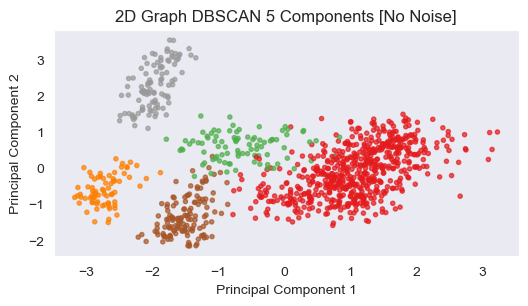

In [60]:
# 2D graph

fig, ax = plt.subplots(figsize=(6, 3), dpi=100)
ax.set_title('2D Graph DBSCAN 5 Components [No Noise]')
ax.set_xlabel('Component: 1')
ax.set_ylabel('Component: 2')

ax.scatter(X['PC1'], X['PC2'], c=X['labels'], cmap=plt.cm.Set1, marker='.',alpha=0.7)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
print(f"Silhouette score: {silhouette_score(X, labels)}")
plt.show()

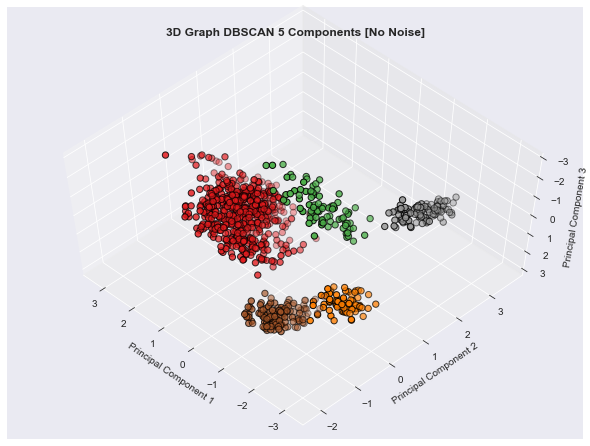

In [61]:
# 3D graph

fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-120, azim=45)
ax.scatter(X['PC1'], X['PC2'], X['PC3'], c=X['labels'], cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("3D Graph DBSCAN 5 Components [No Noise]", fontweight="bold")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")

# plt.savefig("3PCs.png")
plt.show()

In [62]:
# 3D interactive graph

import plotly.express as px

fig = px.scatter_3d(X,
                    x="PC1",
                    y="PC2",
                    z="PC3",
                    template="plotly_dark",
                    color=X['labels'],
                    color_continuous_scale="Viridis",
                   opacity=0.8)
fig.show()

## Testing other models

In [63]:
import itertools as it
def get_params_comb(parameters, clust_technique):
    
    my_dict=parameters.copy()
    
    if clust_technique == 'KMeans': 
        del(my_dict['linkage'])
        
        del(my_dict['eps'])
        del(my_dict['min_samples'])
        
    elif clust_technique == 'Agglomerative':
        del(my_dict['init'])
        del(my_dict['n_init'])
        del(my_dict['max_iter'])
        del(my_dict['random_state'])
        
        del(my_dict['eps'])
        del(my_dict['min_samples'])
        
    elif clust_technique == 'DBSCAN':
        del(my_dict['n_clusters'])
        
        del(my_dict['init'])
        del(my_dict['n_init'])
        del(my_dict['max_iter'])
        del(my_dict['random_state'])
        
        del(my_dict['linkage'])


    allNames = sorted(my_dict)
    combinations = list(it.product(*(my_dict[Name] for Name in allNames)))
    
    return combinations, allNames

In [64]:
def get_params(parameters, iteration, clust_technique):
    
    names = get_params_comb(parameters, clust_technique)[1]
    params = {}
    for n in range(len(names)):
        
        params[names[n]] = get_params_comb(parameters
                                           , clust_technique)[0][iteration][n]

    return params

In [65]:
def pred_clust(X, clust_technique, parameters):
    
    if clust_technique == 'KMeans':
        
        model = KMeans(n_clusters=parameters['n_clusters']
                       , init=parameters['init'], n_init=parameters['n_init']
                       , max_iter=parameters['max_iter']
                       , random_state=parameters['random_state'])
        
        y_pred = model.fit_predict(X)


    elif clust_technique == 'Agglomerative':
        
        model = AgglomerativeClustering(linkage=parameters['linkage']
                                        , n_clusters=parameters['n_clusters']
                                        , affinity=parameters['metric'])
        model.fit(X)
        
        y_pred = model.labels_
        
    elif clust_technique == 'DBSCAN':
        
        model = DBSCAN(eps=parameters['eps']
                      , min_samples=parameters['min_samples']
                      , metric=parameters['metric'])
        model.fit(X)
        y_pred = model.labels_

    return y_pred

In [66]:
def viz_clust(silhouette_vals,y,X): 
    y_ax_lower, y_ax_upper=0,0
    
    f, axes = plt.subplots(1,2, figsize=(10,5))
    
    for i in np.unique(y):
        c_silhouette_vals = silhouette_vals[y==i]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        axes[0].barh(range(y_ax_lower, y_ax_upper)
                         , c_silhouette_vals, height=1)
        y_ax_lower += len(c_silhouette_vals)
        
        axes[1].scatter(X.iloc[y==i,0],X.iloc[y==i,1],s=50,label='cluster '+str(i+1))

    
    silhouette_avg = np.mean(silhouette_vals)
    axes[0].axvline(silhouette_avg, color='red',linestyle='--')
    axes[0].set_ylabel('Cluster')
    axes[0].set_xlabel('Silhouette Coefficient')
    
    axes[1].set_ylabel(X.columns[1])
    axes[1].set_xlabel(X.columns[0])
    plt.show()

In [67]:
X = df.copy()
num = X[['EPC1', 'EPC2', 'EPC3', 'Usage', 'Calls', 'Age']]
cat = X[['Payment', 'Region']]

scaler = StandardScaler()
scaled_X = scaler.fit_transform(num)
scaled_df = pd.DataFrame(scaled_X, columns=[f"{i}_scaled" for i in num.columns])

cat_dummies = pd.get_dummies(cat)

X = pd.concat([scaled_df, cat_dummies], axis=1)

n_components = 5
pca = PCA(n_components)
pca.fit(X)
X_pca = pd.DataFrame(pca.transform(X), columns = [f"PC{i}" for i in range(1,n_components+1)])

tSNE_components = 2
X_tsne = pd.DataFrame(TSNE(n_components=tSNE_components,init='pca').fit_transform(X), columns = [f"tSNE{i}" for i in range(1,tSNE_components+1)])

#### Compare PCA vs tSNE trasformation

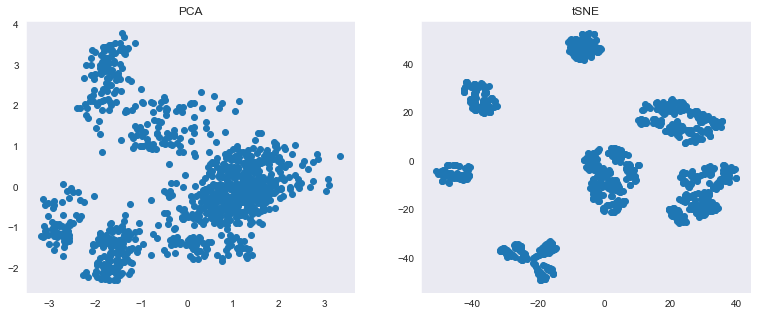

In [68]:
figure,ax = plt.subplots(1,2,figsize=(13,5))
ax[0].scatter(X_pca.iloc[:,0],X_pca.iloc[:,1])
ax[0].set_title('PCA')
ax[1].scatter(X_tsne.iloc[:,0],X_tsne.iloc[:,1])
ax[1].set_title('tSNE')
plt.show()

#### Settings for Grid Search

In [69]:
# Settings
clust_techniques = ['KMeans','Agglomerative','DBSCAN']

visualize = False
verbose = False

parameters = {'metric': ['euclidean']#,'l1','l2','manhattan']
#             Kmeans, Agglomerative  
              , 'n_clusters': [3,4,5,6,7]
#             kMeans params  
              , 'init': ['random','k-means++']
              , 'n_init': [10]
              , 'max_iter': [300]
              , 'random_state': [0]
#             Agglomerative  
              , 'linkage': ['ward', 'average', 'complete', 'single']
#             DBSCAN  
              , 'eps': np.arange(1,2.1,0.1)
              , 'min_samples': np.arange(2,57,4)
             }
print("Possible parameters\n",parameters)
print("\nDataset head\n",X_tsne.head())

Possible parameters
 {'metric': ['euclidean'], 'n_clusters': [3, 4, 5, 6, 7], 'init': ['random', 'k-means++'], 'n_init': [10], 'max_iter': [300], 'random_state': [0], 'linkage': ['ward', 'average', 'complete', 'single'], 'eps': array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]), 'min_samples': array([ 2,  6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50, 54])}

Dataset head
        tSNE1      tSNE2
0  24.347672   7.565217
1  39.912369  -7.014527
2  32.537224  -3.449057
3  39.960220  -7.151280
4  31.028801  11.594218


In [70]:
# Initialize variables
X = X_tsne.copy()
best_silh_list,best_ch_list = [],[]

# Loop: evaluate all the considered clustering techniques
for clust_technique in clust_techniques:
    
    # Initialize variables
    best_silh,best_ch = 0,0
    iterations_number = len(get_params_comb(parameters,clust_technique)[0])
    if verbose:
        print( "\n---------------------------------------------------------------------------------------------------------------\n"
              , "\nClustering technique: ", clust_technique
              , "\nNumber of possible combinations: ",iterations_number,"\n")

    # Loop: evaluate all the possible combinations
    for i in range(iterations_number):
        params = get_params(parameters, i, clust_technique)
        
        if (clust_technique=='Agglomerative'):
            if (params['linkage']=='ward')&(params['metric']!='euclidean'):
                continue
        
        y_pred = pred_clust(X, clust_technique, params)
 
        if len(np.unique(y_pred))<2: continue # in case only 1 cluster is found
        
        silhouette_avg = silhouette_score(X, y_pred, metric=params['metric'])
        
        if verbose:
            print(  "\n- Clustering technique:", clust_technique
                  , "\n- Combination #",i
                  , "\n- Parameters\n",params
                  , "\n\n> The average silhouette_score is:", silhouette_avg)     

        if visualize:
            silhouette_vals = silhouette_samples(X,y_pred,metric=params['metric'])
            viz_clust(silhouette_vals,y_pred,X)

            
        # Update best scores in case of improvement
        # Silhouette score
        if silhouette_avg>best_silh:
            best_silh = silhouette_avg
            best_silh_params = params
            best_silh_i = i
        # Calinski Harabasz Score (variance ratio criterion)
        ch_score = calinski_harabasz_score(X,y_pred)
        if ch_score>best_ch:
            best_ch = ch_score
            best_ch_params = params
            best_ch_i = i
            
    print(  "\n-------------------------------------   SUMMARY",clust_technique,"METHOD   ------------------------------------------"
          , "\n Silhouette"
          , "\n> Best combination #:",best_silh_i
          , "\n> Best AVG SILHOUETTE:",best_silh
          , "\n> Best PARAMETERS:",best_silh_params
          , "\n Calinski-Harabasz"
          , "\n> Best combination #:",best_ch_i
          , "\n> Best C-H SCORE:",best_ch
          , "\n> Best PARAMETERS:",best_ch_params
          , "\n-----------------------------------------------------------------------------------------------------------------\n\n")

    best_silh_dict = {'Method':clust_technique, 'Parameters':best_silh_params, 'Score':best_silh}
    best_silh_list.append(best_silh_dict)
    
    best_ch_dict = {'Method':clust_technique, 'Parameters':best_ch_params, 'Score':best_ch}
    best_ch_list.append(best_ch_dict)

best_list = [best_silh_list,best_ch_list]


-------------------------------------   SUMMARY KMeans METHOD   ------------------------------------------ 
 Silhouette 
> Best combination #: 4 
> Best AVG SILHOUETTE: 0.70673645 
> Best PARAMETERS: {'init': 'random', 'max_iter': 300, 'metric': 'euclidean', 'n_clusters': 7, 'n_init': 10, 'random_state': 0} 
 Calinski-Harabasz 
> Best combination #: 4 
> Best C-H SCORE: 3831.996247378401 
> Best PARAMETERS: {'init': 'random', 'max_iter': 300, 'metric': 'euclidean', 'n_clusters': 7, 'n_init': 10, 'random_state': 0} 
-----------------------------------------------------------------------------------------------------------------



-------------------------------------   SUMMARY Agglomerative METHOD   ------------------------------------------ 
 Silhouette 
> Best combination #: 4 
> Best AVG SILHOUETTE: 0.70673645 
> Best PARAMETERS: {'linkage': 'ward', 'metric': 'euclidean', 'n_clusters': 7} 
 Calinski-Harabasz 
> Best combination #: 4 
> Best C-H SCORE: 3831.996247378401 
> Best PARA

In [71]:
# Select indexes to choose the best result:
# 1) Silhouette score or Calinski-Harabasz score (Variance Ratio criterion)
# 2) Kmeans, Agglomerative or DBSCAN

list_ix = [0,1] # silh-ch, kmean-aggl-dbscan

# Chosen: Silhouette score and Agglomerative

#### Visualize best result from the grid search

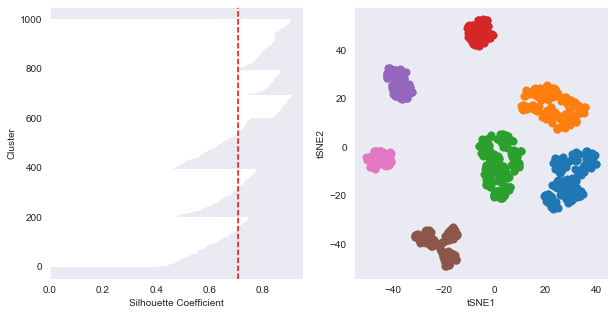


Clustering technique: Agglomerative 
- Parameters
 {'linkage': 'ward', 'metric': 'euclidean', 'n_clusters': 7} 
- The average silhouette_score is: 0.70673645


In [72]:
# Best parameters set
params = best_list[list_ix[0]][list_ix[1]]['Parameters']
# Get the labels
y_pred = pred_clust(X_tsne, best_list[list_ix[0]][list_ix[1]]['Method'], params)
# Get silhouette values
silhouette_vals = silhouette_samples(X_tsne,y_pred,metric=params['metric'])
# Visualize results
viz_clust(silhouette_vals,y_pred,X_tsne)
print(  "\nClustering technique:", best_list[list_ix[0]][list_ix[1]]['Method']
      , "\n- Parameters\n",params
      , "\n- The average silhouette_score is:", np.mean(silhouette_vals))

#### Compare PCA vs tSNE transformations with predicted labels

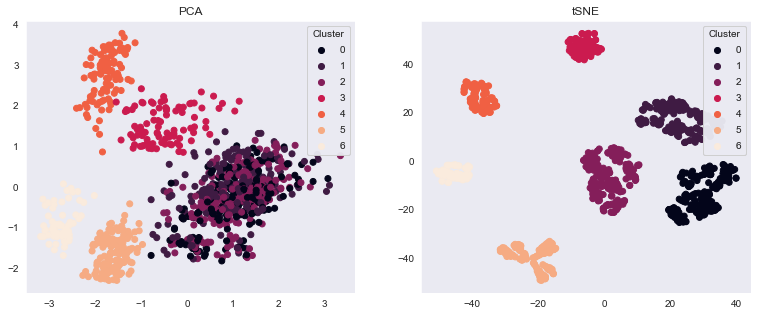

In [73]:
figure,ax = plt.subplots(1,2,figsize=(13,5))

scatter0 = ax[0].scatter(X_pca.iloc[:,0],X_pca.iloc[:,1],c=y_pred)
ax[0].set_title('PCA')
ax[0].add_artist(ax[0].legend(*scatter0.legend_elements(), loc="upper right", title="Cluster"))


scatter1 = ax[1].scatter(X_tsne.iloc[:,0],X_tsne.iloc[:,1],c=y_pred)
ax[1].set_title('tSNE')
ax[1].add_artist(ax[1].legend(*scatter1.legend_elements(), loc="upper right", title="Cluster"))

plt.show()

Think of clustering together 3 clusters which overlapped in the PCA plot

In [74]:
y_pred_new = [0 if y in [0,1,2] else y for y in y_pred]

#### Visualize with 5 clusters

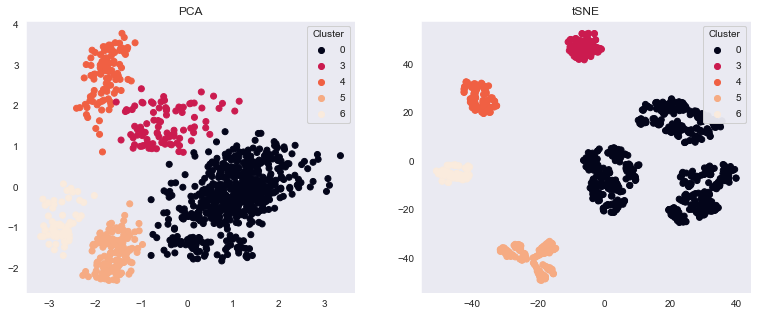

In [75]:
figure,ax = plt.subplots(1,2,figsize=(13,5))

scatter0 = ax[0].scatter(X_pca.iloc[:,0],X_pca.iloc[:,1],c=y_pred_new)
ax[0].set_title('PCA')
ax[0].add_artist(ax[0].legend(*scatter0.legend_elements(), loc="upper right", title="Cluster"))

scatter1 = ax[1].scatter(X_tsne.iloc[:,0],X_tsne.iloc[:,1],c=y_pred_new)
ax[1].set_title('tSNE')
ax[1].add_artist(ax[1].legend(*scatter1.legend_elements(), loc="upper right", title="Cluster"))
plt.show()

# Clusters Description

In [90]:
df_descr = pd.concat([num, cat
                      , pd.DataFrame(y_pred,columns=['Label_7'])
                      , pd.DataFrame(y_pred_new,columns=['Label_5'])], axis=1)

In [91]:
X = df.copy()
num = X[['EPC1', 'EPC2', 'EPC3', 'Usage', 'Calls', 'Age']]
cat = X[['Payment','Region']]

df_descr = pd.concat([num, cat
                      , pd.DataFrame(y_pred,columns=['Label_7'])
                      , pd.DataFrame(y_pred_new,columns=['Label_5'])], axis=1)

#### 7 Clusters visualization

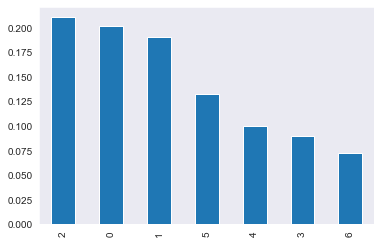

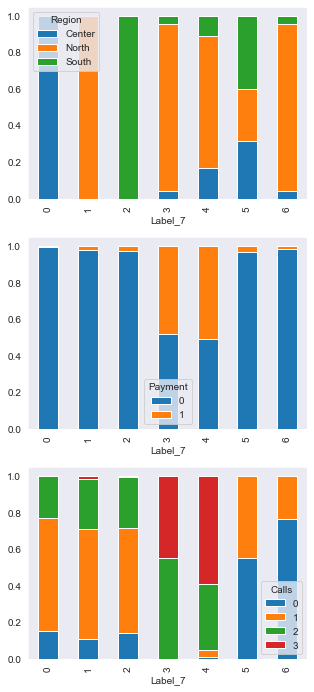

In [92]:
df_descr.Label_7.value_counts(normalize=True).plot.bar()
df_descr.Label_7.value_counts()
cat_list = [c for c in ['Region','Payment','Calls']]
f, axes = plt.subplots(len(cat_list), 1, figsize=(5,4*len(cat_list)))
for c in range(len(cat_list)):
    pd.crosstab(df_descr.Label_7,df_descr.loc[:,cat_list[c]],normalize='index')\
        .plot.bar(stacked=True, ax=axes[c])

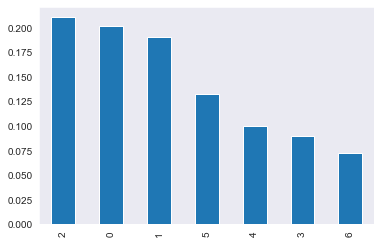

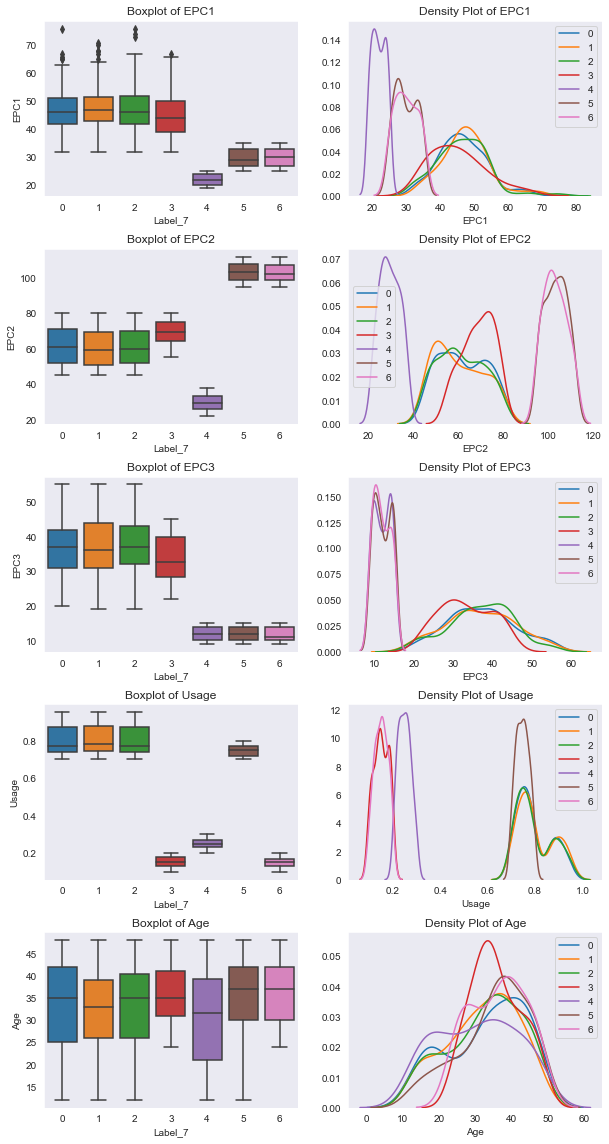

In [93]:
df_descr.Label_7.value_counts(normalize=True).plot.bar()
df_descr.Label_7.value_counts()
num_ls  = ['EPC1', 'EPC2', 'EPC3', 'Usage', 'Age']
hue = 'Label_7'

f, axes = plt.subplots(len(num_ls), 2, figsize=(10,4*len(num_ls)))

for num_ix in range(len(num_ls)):
    num_var = num_ls[num_ix]

    variable_to_plot = df_descr.loc[:,num_var]
    title_str = num_var

    sns.boxplot(x=df_descr.loc[:,hue],y=variable_to_plot, ax=axes[num_ix,0])
    for hue_val in np.unique(df_descr.loc[:,hue]):
        sns.distplot(variable_to_plot[df_descr.loc[:,hue]==hue_val], hist = False, ax=axes[num_ix,1],label=hue_val)

    axes[num_ix,0].set_title('Boxplot of '+title_str)        
    axes[num_ix,1].set_title('Density Plot of '+title_str) 
    
plt.subplots_adjust(hspace=0.3)
plt.show()

#### 5 Clusters visualization

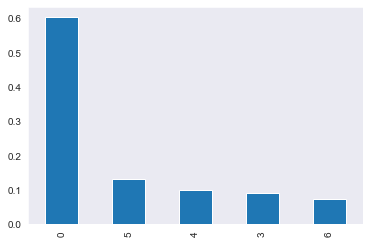

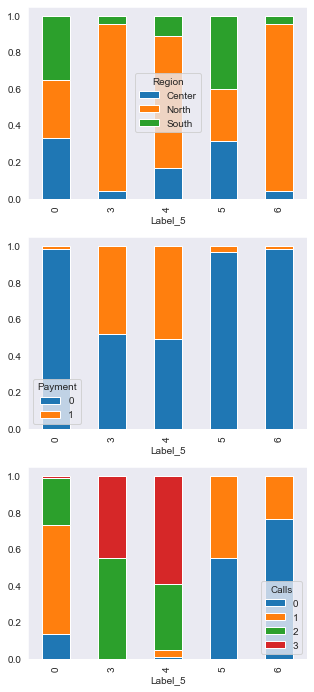

In [94]:
df_descr.Label_5.value_counts(normalize=True).plot.bar()
df_descr.Label_5.value_counts()
cat_list = [c for c in ['Region','Payment','Calls']]
f, axes = plt.subplots(len(cat_list), 1, figsize=(5,4*len(cat_list)))
for c in range(len(cat_list)):
    pd.crosstab(df_descr.Label_5,df_descr.loc[:,cat_list[c]],normalize='index')\
        .plot.bar(stacked=True, ax=axes[c])

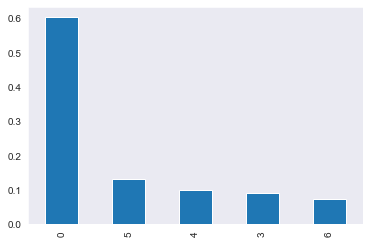

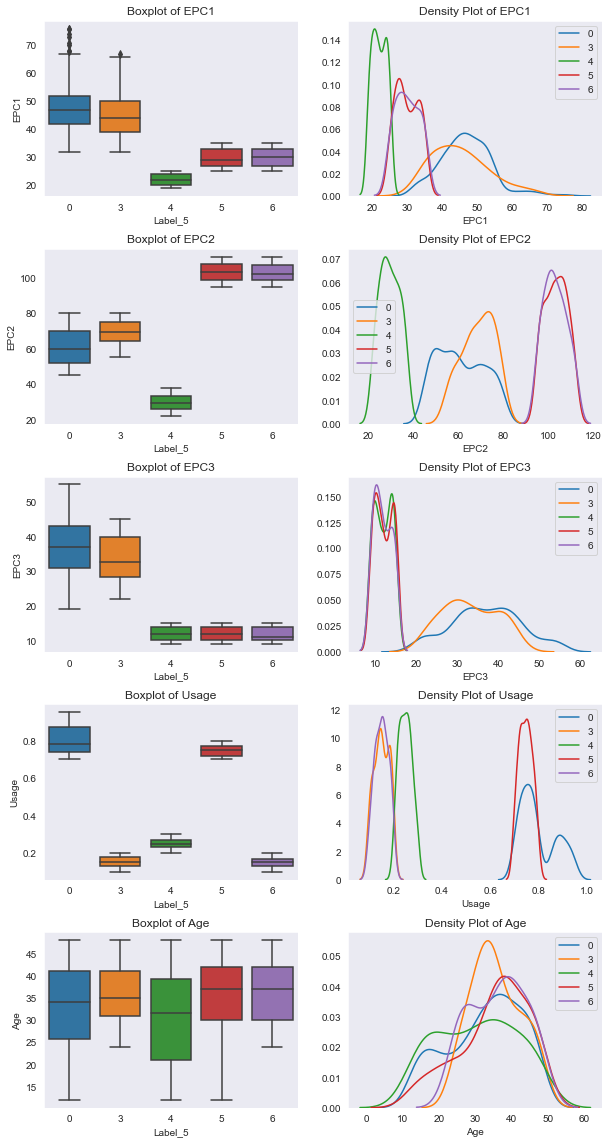

In [95]:
df_descr.Label_5.value_counts(normalize=True).plot.bar()
df_descr.Label_5.value_counts()

num_ls  = ['EPC1', 'EPC2', 'EPC3', 'Usage', 'Age']
hue = 'Label_5'

f, axes = plt.subplots(len(num_ls), 2, figsize=(10,4*len(num_ls)))

for num_ix in range(len(num_ls)):
    num_var = num_ls[num_ix]

    variable_to_plot = df_descr.loc[:,num_var]
    title_str = num_var

    sns.boxplot(x=df_descr.loc[:,hue],y=variable_to_plot, ax=axes[num_ix,0])
    for hue_val in np.unique(df_descr.loc[:,hue]):
        sns.distplot(variable_to_plot[df_descr.loc[:,hue]==hue_val], hist = False, ax=axes[num_ix,1],label=hue_val)

    axes[num_ix,0].set_title('Boxplot of '+title_str)        
    axes[num_ix,1].set_title('Density Plot of '+title_str) 
    
plt.subplots_adjust(hspace=0.3)
plt.show()

For the interpretation of the results, we redirect to the report.